In [2]:
%pip install pytorch-lightning

In [3]:
import sys
import os

def is_colab_env():
    return "google.colab" in sys.modules

def mount_google_drive(drive_dir="/content/drive/", repo_dir="MyDrive/repositories/deepfake-detection"):
    # mount google drive
    from google.colab import drive
    drive.mount(drive_dir)

    # change to correct working directory
    import os
    repo_dir = f"{drive_dir}{repo_dir}"
    os.chdir(repo_dir)
    print(os.listdir()) # verify content
    return repo_dir

def resolve_path(levels_deep=3):
    if is_colab_env():
        return mount_google_drive()
    else:
        # Get the directory of the current script
        current_dir = os.path.dirname(os.path.abspath('__file__'))

        # Construct the path to the parent directory
        for i in range(levels_deep):
            current_dir = os.path.dirname(current_dir)

        # Add the parent directory to sys.path
        sys.path.append(current_dir)
        print(sys.path)
        return current_dir

proj_dir = resolve_path()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['src', '.git', 'playground', 'reports', 'analysis', 'faceforensics_download.py', 'freqnet_image.ipynb', 'hf_wdf.sh', 'run_jupyter.sh', 'setup', 'config.py', 'preprocessing', 'README.md', 'samples', '.gitignore', '__pycache__', 'server.py', 'environment.yml']


In [4]:
import config
import numpy as np
from PIL import Image
import cv2
from src.model_registry import MODEL_REGISTRRY

face_cascade = cv2.CascadeClassifier(proj_dir + '/preprocessing/haarcascade_frontalface_default.xml')

In [5]:
# pytorch
import torch
import pytorch_lightning as L

In [6]:
# import local dependencies
from src.models.resnet import ResNetClassifier
from src.transforms.frequency import get_transforms

In [7]:
model_id = "dwt_rgb_resnet18"
model_checkpoint_dir = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}"

In [8]:
seed = config.SEED

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [9]:
models = {}
transforms = {}

for model_id, spec in MODEL_REGISTRRY.items():
    ckpt_path = f"{proj_dir}/{config.CHECKPOINTS_DIR}/{model_id}/{spec['checkpoint']}"
    model = ResNetClassifier.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        in_channels=spec.get("in_channels", 3),
        freeze_features=False,
        weights_only=False,
    )
    model.eval()
    models[model_id] = model
    transforms[model_id] = get_transforms(mode=spec["transforms_mode"], image_size=224)

In [10]:
def get_cropped_face(img_data, crop_factor=1.1):
    """
    Detects a face in an image and returns the cropped face as a NumPy array.

    :param img_data: The input image as a NumPy array (BGR format).
    :param crop_factor: Factor to extend the bounding box.
    :return: A NumPy array representing the cropped BGR face, or None if no face is found.
    """
    img = img_data
    if img is None or img.size == 0:
        print("Error: Empty image data provided.")
        return None

    # 1. Convert to grayscale for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Detect faces
    faces = face_cascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30)
    )

    if len(faces) == 0:
        print("No face detected.")
        return None

    # 3. Crop the largest face (assuming the main subject is the largest face)
    (x, y, w, h) = sorted(faces, key=lambda f: f[2] * f[3], reverse=True)[0]

    # 4. Apply a 'crop factor' for padding
    center_x = x + w // 2
    center_y = y + h // 2
    size = int(max(w, h) * crop_factor)

    # Calculate the coordinates for the padded square crop
    x_start = max(0, center_x - size // 2)
    y_start = max(0, center_y - size // 2)
    x_end = min(img.shape[1], center_x + size // 2)
    y_end = min(img.shape[0], center_y + size // 2)

    # Adjust start/end if clipping occurred to ensure a square crop
    final_size = min(x_end - x_start, y_end - y_start)

    # Final Crop
    cropped_face = img[y_start : y_start + final_size, x_start : x_start + final_size]

    return cropped_face

In [11]:
import os
import glob
import pandas as pd
import torch
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Configuration
# Update this path to where you stored your external_test folder
TEST_DIR = proj_dir + "/samples"

# Define your categories and their Ground Truth label (0=Real, 1=Fake)
category_map = {
    'real': 0,
    'gan': 1,       # This Person Does Not Exist
    'diffusion': 1  # Stable Diffusion
}


print(f"Starting evaluation for all models...")

# Initialize a list to store metrics for all models
all_models_metrics_data = []

# Iterate through all models in MODEL_REGISTRRY
for model_id_loop, spec_loop in MODEL_REGISTRRY.items():
    model_id = model_id_loop # Assign current model_id for clarity
    print(f"\nEvaluating model: {model_id}")

    # Store results for the current model
    results_data = []

    # 2. Inference Loop
    for category, ground_truth in category_map.items():
        folder_path = os.path.join(TEST_DIR, category)
        # Grab jpg, png, and jpeg files
        image_files = glob.glob(os.path.join(folder_path, "*"))

        print(f"Processing {category} ({len(image_files)} images) for {model_id}...")

        for img_path in image_files:
            try:
                # --- A. Preprocessing (Your existing pipeline) ---
                # Load image
                new_image_pil = Image.open(img_path).convert('RGB') # Ensure RGB
                new_image_np_rgb = np.array(new_image_pil)
                new_image_np_bgr = cv2.cvtColor(new_image_np_rgb, cv2.COLOR_RGB2BGR)

                # Detect and Crop Face
                cropped_face_np_bgr = get_cropped_face(new_image_np_bgr)

                if cropped_face_np_bgr is None:
                    # print(f"  [Skipping] No face detected in {os.path.basename(img_path)}, using entire image.")
                    cropped_face_np_bgr = new_image_np_bgr

                # Convert back to PIL for transforms
                cropped_face_pil_rgb = Image.fromarray(cv2.cvtColor(cropped_face_np_bgr, cv2.COLOR_BGR2RGB))

                # --- B. Model Inference ---
                # Apply transforms (DWT + RGB processing)
                transformed_input = transforms[model_id]['test'](cropped_face_pil_rgb)
                input_tensor = transformed_input.unsqueeze(0).to(device)

                with torch.no_grad():
                    output = models[model_id](input_tensor)
                    prob = torch.sigmoid(output).item()
                    prediction = 1 if prob > 0.5 else 0

                # --- C. Store Result ---
                results_data.append({
                    'filename': os.path.basename(img_path),
                    'category': category,       # 'real', 'gan', or 'diffusion'
                    'ground_truth': ground_truth,
                    'prediction': prediction,
                    'probability': prob
                })

            except Exception as e:
                print(f"  [Error] Could not process {os.path.basename(img_path)} for model {model_id}: {e}")

    # 3. Calculate and Print Metrics for the current model
    df = pd.DataFrame(results_data)

    if df.empty:
        print(f"No images processed successfully for model {model_id}.")
        continue # Skip to next model if no data

    print("\n" + "="*40)
    print(f"  EXTERNAL GENERALIZATION REPORT: {model_id}")
    print("="*40)

    # --- Overall Metrics ---
    acc = accuracy_score(df['ground_truth'], df['prediction'])
    f1 = f1_score(df['ground_truth'], df['prediction'], pos_label=1)
    try:
        auc = roc_auc_score(df['ground_truth'], df['probability'])
    except ValueError: # Handle case if only one class exists in prediction
        auc = np.nan # Use NaN for AUC if it cannot be calculated

    print(f"OVERALL Performance (All 3 categories):")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC:      {auc:.4f}")
    print("-" * 40)

    # --- Per-Category Breakdown (The "Analysis" part) ---
    model_metrics = {
        'model_id': model_id,
        'overall_accuracy': acc,
        'overall_f1_score': f1,
        'overall_auc': auc
    }

    print("PER-CATEGORY BREAKDOWN:")
    for cat in category_map.keys():
        subset = df[df['category'] == cat]
        if len(subset) == 0:
            model_metrics[f'{cat}_accuracy'] = np.nan
            continue

        # Calculate accuracy for this subset
        subset_acc = accuracy_score(subset['ground_truth'], subset['prediction'])
        model_metrics[f'{cat}_accuracy'] = subset_acc

        print(f"  Category: {cat.upper():<10} | Accuracy: {subset_acc:.4f} ({len(subset)} samples)")

    print("-" * 40)

    # --- Specific Contrast: GAN vs Diffusion ---
    # This is great for your report's "Generalization" discussion
    gan_subset = df[df['category'] == 'gan']
    diff_subset = df[df['category'] == 'diffusion']

    gan_acc = np.nan
    diff_acc = np.nan

    if not gan_subset.empty:
        gan_acc = accuracy_score(gan_subset['ground_truth'], gan_subset['prediction'])
    if not diff_subset.empty:
        diff_acc = accuracy_score(diff_subset['ground_truth'], diff_subset['prediction'])

    model_metrics['gan_accuracy'] = gan_acc
    model_metrics['diffusion_accuracy'] = diff_acc

    if not gan_subset.empty and not diff_subset.empty:
        print(f"ROBUSTNESS CHECK:")
        print(f"  GAN Accuracy:       {gan_acc:.4f}")
        print(f"  Diffusion Accuracy: {diff_acc:.4f}")
        if diff_acc < gan_acc:
            print("  -> Conclusion: Model struggles more with Diffusion (unseen architecture).")
        else:
            print("  -> Conclusion: Model generalizes well to Diffusion!")
    elif not gan_subset.empty:
        print(f"ROBUSTNESS CHECK: GAN Accuracy: {gan_acc:.4f}")
    elif not diff_subset.empty:
        print(f"ROBUSTNESS CHECK: Diffusion Accuracy: {diff_acc:.4f}")


    all_models_metrics_data.append(model_metrics)

# 4. Save all models' metrics to a file
if all_models_metrics_data:
    metrics_df = pd.DataFrame(all_models_metrics_data)
    output_filename = f"{proj_dir}/model_evaluation_metrics.csv"
    metrics_df.to_csv(output_filename, index=False)
    print(f"\nAll model evaluation metrics saved to: {output_filename}")
    display(metrics_df)
else:
    print("\nNo metrics collected for any models.")

Starting evaluation for all models...

Evaluating model: dct_resnet18
Processing real (30 images) for dct_resnet18...
No face detected.
No face detected.
No face detected.
Processing gan (30 images) for dct_resnet18...
Processing diffusion (30 images) for dct_resnet18...
No face detected.
No face detected.

  EXTERNAL GENERALIZATION REPORT: dct_resnet18
OVERALL Performance (All 3 categories):
  Accuracy: 0.4667
  F1-Score: 0.4146
  AUC:      0.6178
----------------------------------------
PER-CATEGORY BREAKDOWN:
  Category: REAL       | Accuracy: 0.8333 (30 samples)
  Category: GAN        | Accuracy: 0.1333 (30 samples)
  Category: DIFFUSION  | Accuracy: 0.4333 (30 samples)
----------------------------------------
ROBUSTNESS CHECK:
  GAN Accuracy:       0.1333
  Diffusion Accuracy: 0.4333
  -> Conclusion: Model generalizes well to Diffusion!

Evaluating model: dwt_resnet18
Processing real (30 images) for dwt_resnet18...
No face detected.
No face detected.
No face detected.
Processing g

,model_id,overall_accuracy,overall_f1_score,overall_auc,real_accuracy,gan_accuracy,diffusion_accuracy
0,dct_resnet18,0.466667,0.414634,0.617778,0.833333,0.133333,0.433333
1,dwt_resnet18,0.744444,0.803419,0.847222,0.666667,0.833333,0.733333
2,dwt_rgb_resnet18,0.755556,0.810345,0.758333,0.700000,0.800000,0.766667
3,fft_magnitude_phase_resnet18,0.322222,0.061538,0.371111,0.900000,0.033333,0.033333
4,rgb_resnet18,0.555556,0.534884,0.686667,0.900000,0.466667,0.300000


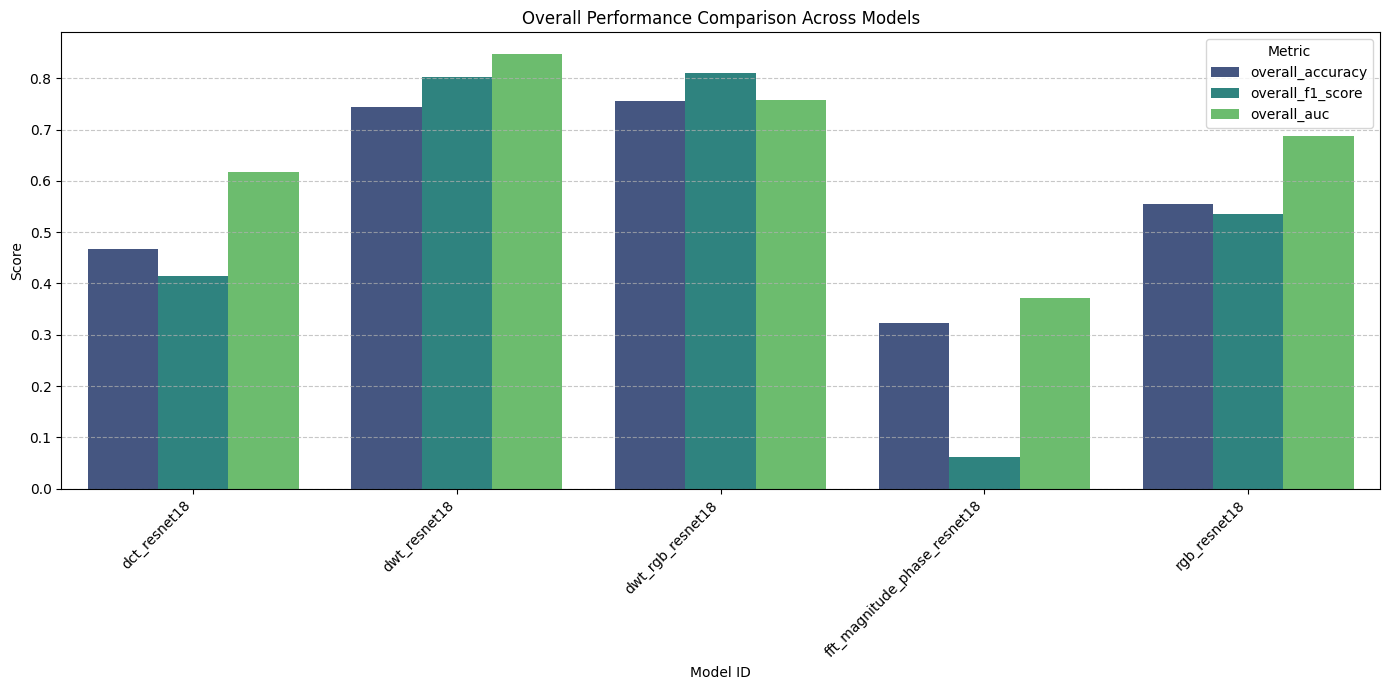

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure metrics_df is available from previous execution if not already in kernel
if 'metrics_df' not in locals():
    try:
        metrics_df = pd.read_csv(f"{proj_dir}/model_evaluation_metrics.csv")
        print("Loaded metrics_df from file.")
    except FileNotFoundError:
        print("Error: model_evaluation_metrics.csv not found. Please run the evaluation cell first.")
        metrics_df = pd.DataFrame() # Create empty DataFrame to avoid errors

if not metrics_df.empty:
    # 1. Overall Performance Comparison Plot
    # Melt the DataFrame to prepare for seaborn barplot
    overall_metrics_melted = metrics_df.melt(id_vars=['model_id'],
                                             value_vars=['overall_accuracy', 'overall_f1_score', 'overall_auc'],
                                             var_name='Metric', value_name='Score')

    plt.figure(figsize=(14, 7))
    sns.barplot(x='model_id', y='Score', hue='Metric', data=overall_metrics_melted, palette='viridis')
    plt.title('Overall Performance Comparison Across Models')
    plt.xlabel('Model ID')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate plots: metrics_df is empty.")

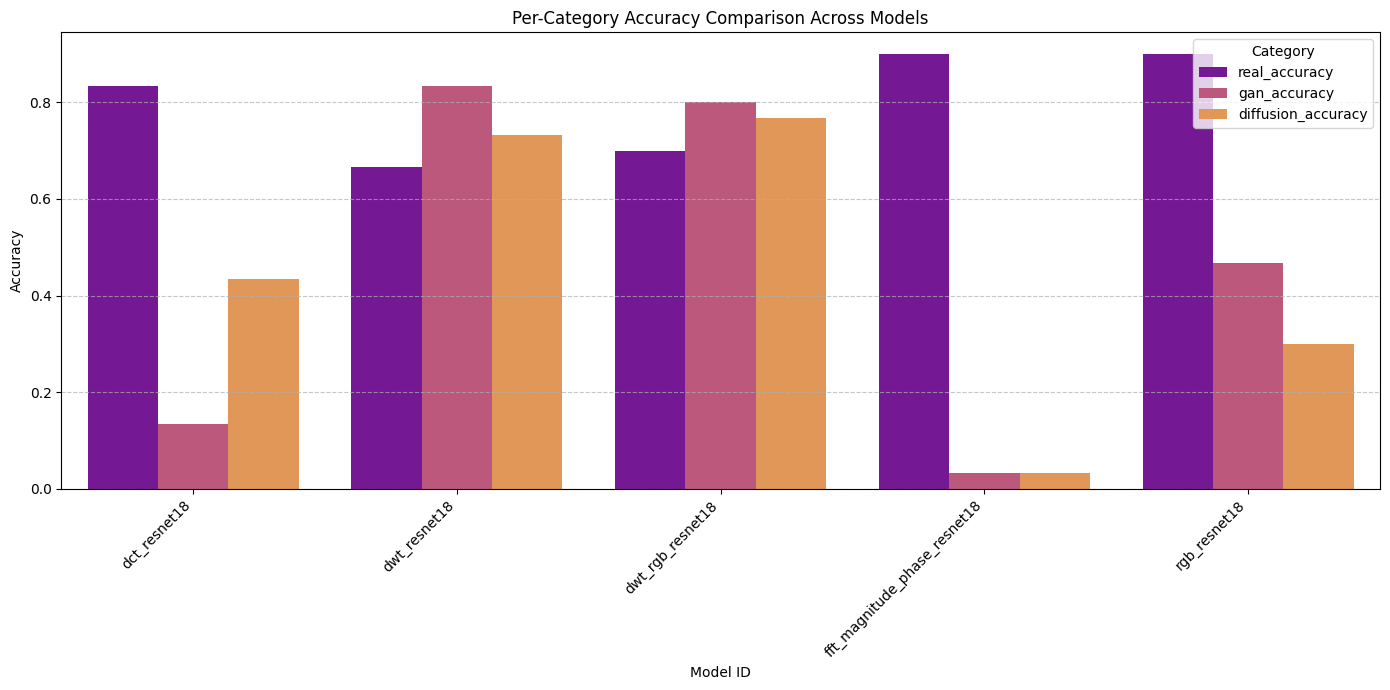

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure metrics_df is available
if 'metrics_df' not in locals():
    try:
        metrics_df = pd.read_csv(f"{proj_dir}/model_evaluation_metrics.csv")
        print("Loaded metrics_df from file.")
    except FileNotFoundError:
        print("Error: model_evaluation_metrics.csv not found. Please run the evaluation cell first.")
        metrics_df = pd.DataFrame() # Create empty DataFrame to avoid errors

if not metrics_df.empty:
    # 2. Per-Category Accuracy Breakdown Plot
    per_category_melted = metrics_df.melt(id_vars=['model_id'],
                                          value_vars=['real_accuracy', 'gan_accuracy', 'diffusion_accuracy'],
                                          var_name='Category', value_name='Accuracy')

    plt.figure(figsize=(14, 7))
    sns.barplot(x='model_id', y='Accuracy', hue='Category', data=per_category_melted, palette='plasma')
    plt.title('Per-Category Accuracy Comparison Across Models')
    plt.xlabel('Model ID')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Category')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Cannot generate plots: metrics_df is empty.")